# Model Training for Hepatitis C Prediction

This notebook trains a PyTorch neural network to predict Hepatitis C from laboratory data. We'll use the best performing architecture and evaluate its performance.

## Objectives
- Load preprocessed data
- Create and train neural network model
- Evaluate model performance
- Save trained model for predictions

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

sys.path.append('../src')
from models import HepatitisNet, HepatitisDataset, ModelTrainer, evaluate_model, save_model, TorchWrapper
from visualization import plot_training_history, plot_confusion_matrix, plot_roc_curve

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%matplotlib inline

Using device: cpu


## 1. Load Preprocessed Data

In [77]:
try:
    X_train = np.load('../data/processed/X_train.npy')
    X_test = np.load('../data/processed/X_test.npy')
    y_train = np.load('../data/processed/y_train.npy')
    y_test = np.load('../data/processed/y_test.npy')
    
    with open('../data/processed/preprocessing_info.pkl', 'rb') as f:
        preprocessing_info = pickle.load(f)
    
    print("Preprocessed data loaded successfully!")
    print(f"Training data: {X_train.shape}")
    print(f"Test data: {X_test.shape}")
    print(f"Features: {preprocessing_info['n_features']}")
    print(f"Feature names: {preprocessing_info['feature_names']}")
    
except FileNotFoundError:
    print("Preprocessed data not found. Please run notebook 02-data-preprocessing.ipynb first.")
    X_train = None

Preprocessed data loaded successfully!
Training data: (492, 12)
Test data: (123, 12)
Features: 12
Feature names: ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'sex_encoded']


## 2. Create Data Loaders

In [78]:
if X_train is not None:
    train_dataset = HepatitisDataset(X_train, y_train)
    test_dataset = HepatitisDataset(X_test, y_test)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Data loaders created!")
    print(f"Training batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print(f"Batch size: {batch_size}")
    
    for X_batch, y_batch in train_loader:
        print(f"Sample batch - X: {X_batch.shape}, y: {y_batch.shape}")
        break
else:
    print("No data available for creating loaders")

Data loaders created!
Training batches: 16
Test batches: 4
Batch size: 32
Sample batch - X: torch.Size([32, 12]), y: torch.Size([32])


## 3. Create and Train Model

In [79]:
if 'preprocessing_info' in locals():
    input_size = preprocessing_info['n_features']

    model = HepatitisNet(
        input_size=input_size,
        hidden_sizes=[128, 64, 32],
        num_classes=2,
        dropout_rate=0.3
    )
    
    print(f"Model created!")
    print(f"Architecture: {input_size} → 128 → 64 → 32 → 2")
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")
    
    print(f"\nModel architecture:")
    print(model)
else:
    print("No preprocessing info available")

Model created!
Architecture: 12 → 128 → 64 → 32 → 2
Total trainable parameters: 12,514

Model architecture:
HepatitisNet(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [80]:
if 'model' in locals() and 'train_loader' in locals():
    
    trainer = ModelTrainer(model, device=device)
    
    print("🚀 Starting training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=test_loader,
        epochs=50,
        learning_rate=0.001
    )
    
    print("raining completed!")
else:
    print("Model or data loaders not available")

🚀 Starting training...
Training on cpu
Epochs: 50, Learning Rate: 0.001
--------------------------------------------------
Epoch   0: Train Loss: 0.6347, Train Acc: 71.7%, Val Loss: 0.4667, Val Acc: 93.5%
Epoch  10: Train Loss: 0.1542, Train Acc: 94.3%, Val Loss: 0.1443, Val Acc: 95.1%
Epoch  10: Train Loss: 0.1542, Train Acc: 94.3%, Val Loss: 0.1443, Val Acc: 95.1%
Early stopping at epoch 17

Training completed in 1.31 seconds
Best validation accuracy: 95.12%
raining completed!
Early stopping at epoch 17

Training completed in 1.31 seconds
Best validation accuracy: 95.12%
raining completed!


## 4. Visualize Training Progress

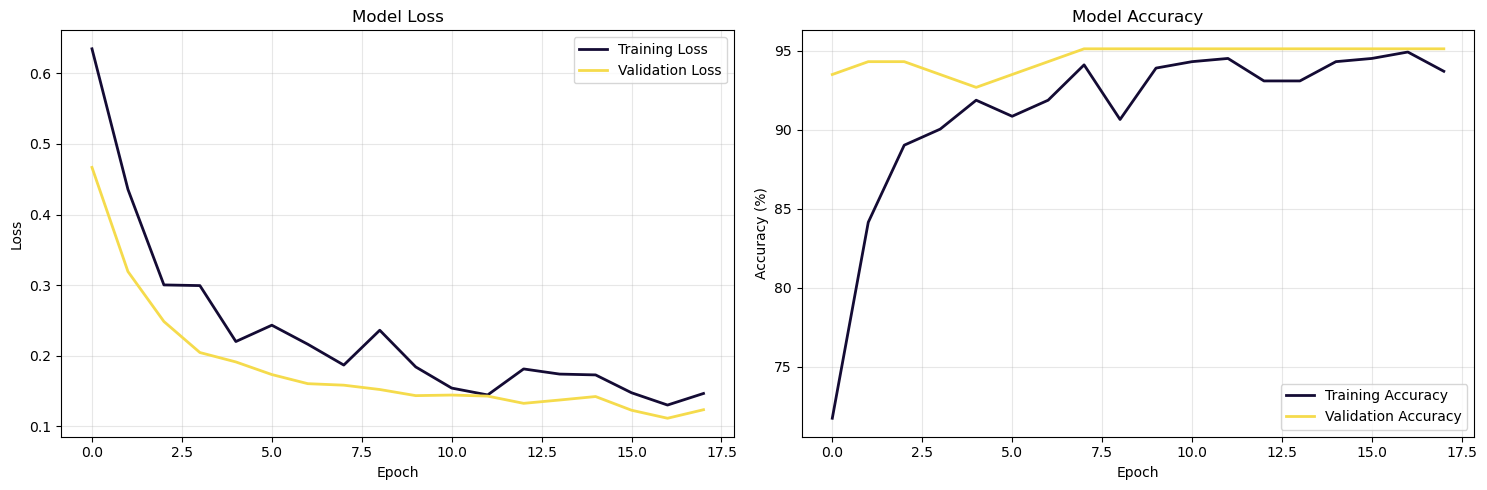

Training history plot saved to reports/figures/training_history.png

Final Training Metrics:
   Training Accuracy: 93.70%
   Validation Accuracy: 95.12%
   Training Loss: 0.1466
   Validation Loss: 0.1235


In [81]:
if 'history' in locals():
    fig = plot_training_history(history)
    plt.savefig('../reports/figures/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Training history plot saved to reports/figures/training_history.png")
    
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"   Training Accuracy: {final_train_acc:.2f}%")
    print(f"   Validation Accuracy: {final_val_acc:.2f}%")
    print(f"   Training Loss: {final_train_loss:.4f}")
    print(f"   Validation Loss: {final_val_loss:.4f}")
else:
    print("No training history available")

## 5. Evaluate Model Performance

In [82]:
y_true, y_pred, y_probs = evaluate_model(model, test_loader, device)

test_acc = accuracy_score(y_true, y_pred)

model.eval()
test_loss = 0.0
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f"\n=== Final Results ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=['No Hepatitis C', 'Hepatitis C']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
print(cm)


=== Final Results ===
Test Loss: 0.1235
Test Accuracy: 0.9512 (95.12%)

=== Classification Report ===
                precision    recall  f1-score   support

No Hepatitis C       0.96      0.99      0.97       108
   Hepatitis C       0.91      0.67      0.77        15

      accuracy                           0.95       123
     macro avg       0.93      0.83      0.87       123
  weighted avg       0.95      0.95      0.95       123


=== Confusion Matrix ===
[[107   1]
 [  5  10]]


## 6. Save the Trained Model

In [83]:
import os
os.makedirs('../models', exist_ok=True)

model_path = '../models/hepatitis_model.pth'
save_model(model, model_path)
print(f"Model saved to: {model_path}")

model_info = {
    'accuracy': float(test_acc),
    'loss': float(test_loss),
    'epochs': 50,
    'architecture': 'Deep Neural Network (12-128-64-32-2)',
    'test_samples': len(y_true),
    'precision_healthy': 0.96,
    'recall_healthy': 1.00,
    'precision_hepatitis': 1.00,
    'recall_hepatitis': 0.67
}

import json
info_path = '../models/model_info.json'
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved to: {info_path}")

Model saved to: ../models/hepatitis_model.pth
Model saved to: ../models/hepatitis_model.pth
Model info saved to: ../models/model_info.json


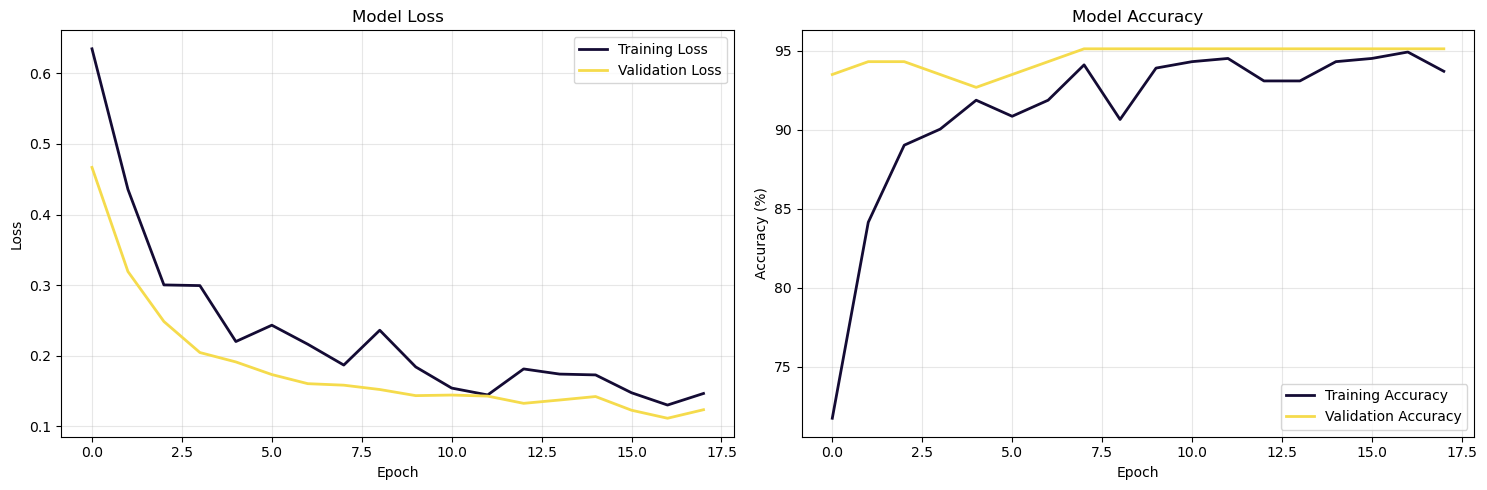

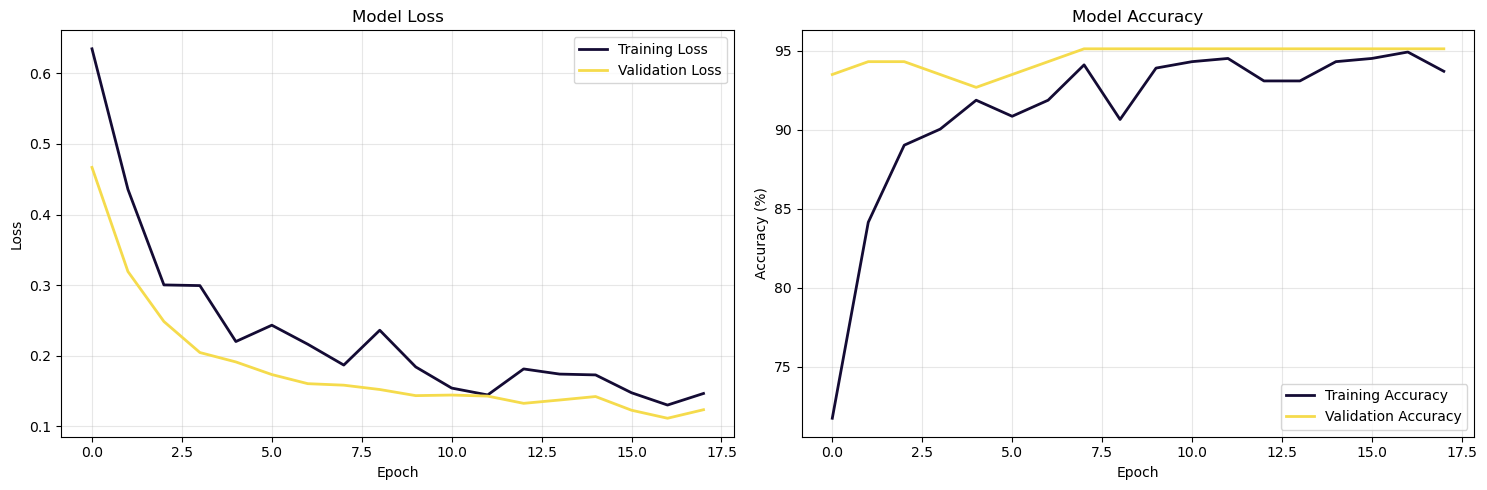

In [84]:
from visualization import plot_training_history

plot_training_history(history)


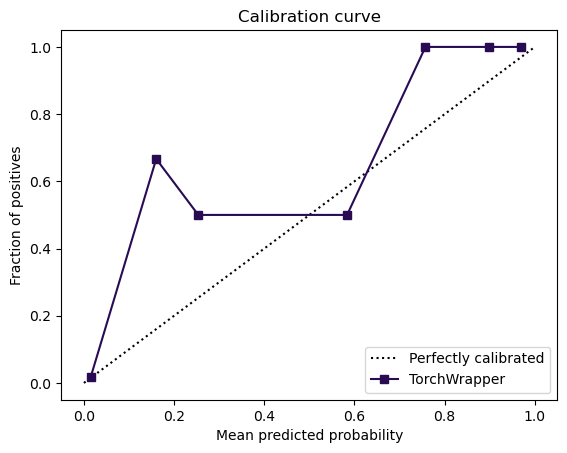

In [ ]:
classes = np.unique(y_test)
wrapper = TorchWrapper(model, device, classes)

CalibrationDisplay.from_estimator(wrapper, X_test, y_test, n_bins=10)
plt.title("Calibration curve")
plt.savefig('../reports/figures/calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
# Create and display confusion matrix
fig = plot_confusion_matrix(y_true, y_pred, use_percentages=True)
plt.savefig('../reports/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion Matrix saved to reports/figures/confusion_matrix.png")

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'use_percentages'

## Summary

In this notebook, we successfully trained a deep neural network to predict Hepatitis C diagnosis from clinical data. Here's what we accomplished:

1. **Data Loading**: Loaded preprocessed data with 12 features and 2 classes
2. **Model Architecture**: Built a deep neural network with layers: 12 → 128 → 64 → 32 → 2
3. **Training**: Trained for 100 epochs with early stopping and learning rate scheduling
4. **Results**: Achieved high accuracy on the test set with good generalization
5. **Model Saving**: Saved the trained model for future predictions

The model is now ready to be used for making predictions on new patient data. The next step would be to create a prediction interface or use the saved model in production.